<a href="https://colab.research.google.com/github/Edsondev21/Projet_7/blob/main/P7_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import plotting
import matplotlib as mpl
import missingno as msno

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install lightgbm==3.3.1

     |████████████████████████████████| 2.0 MB 6.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


# 1) Nettoyage et Analyse


In [ ]:
d1 = pd.read_csv('/content/drive/MyDrive/application_train.csv')

d1.shape

(307511, 122)

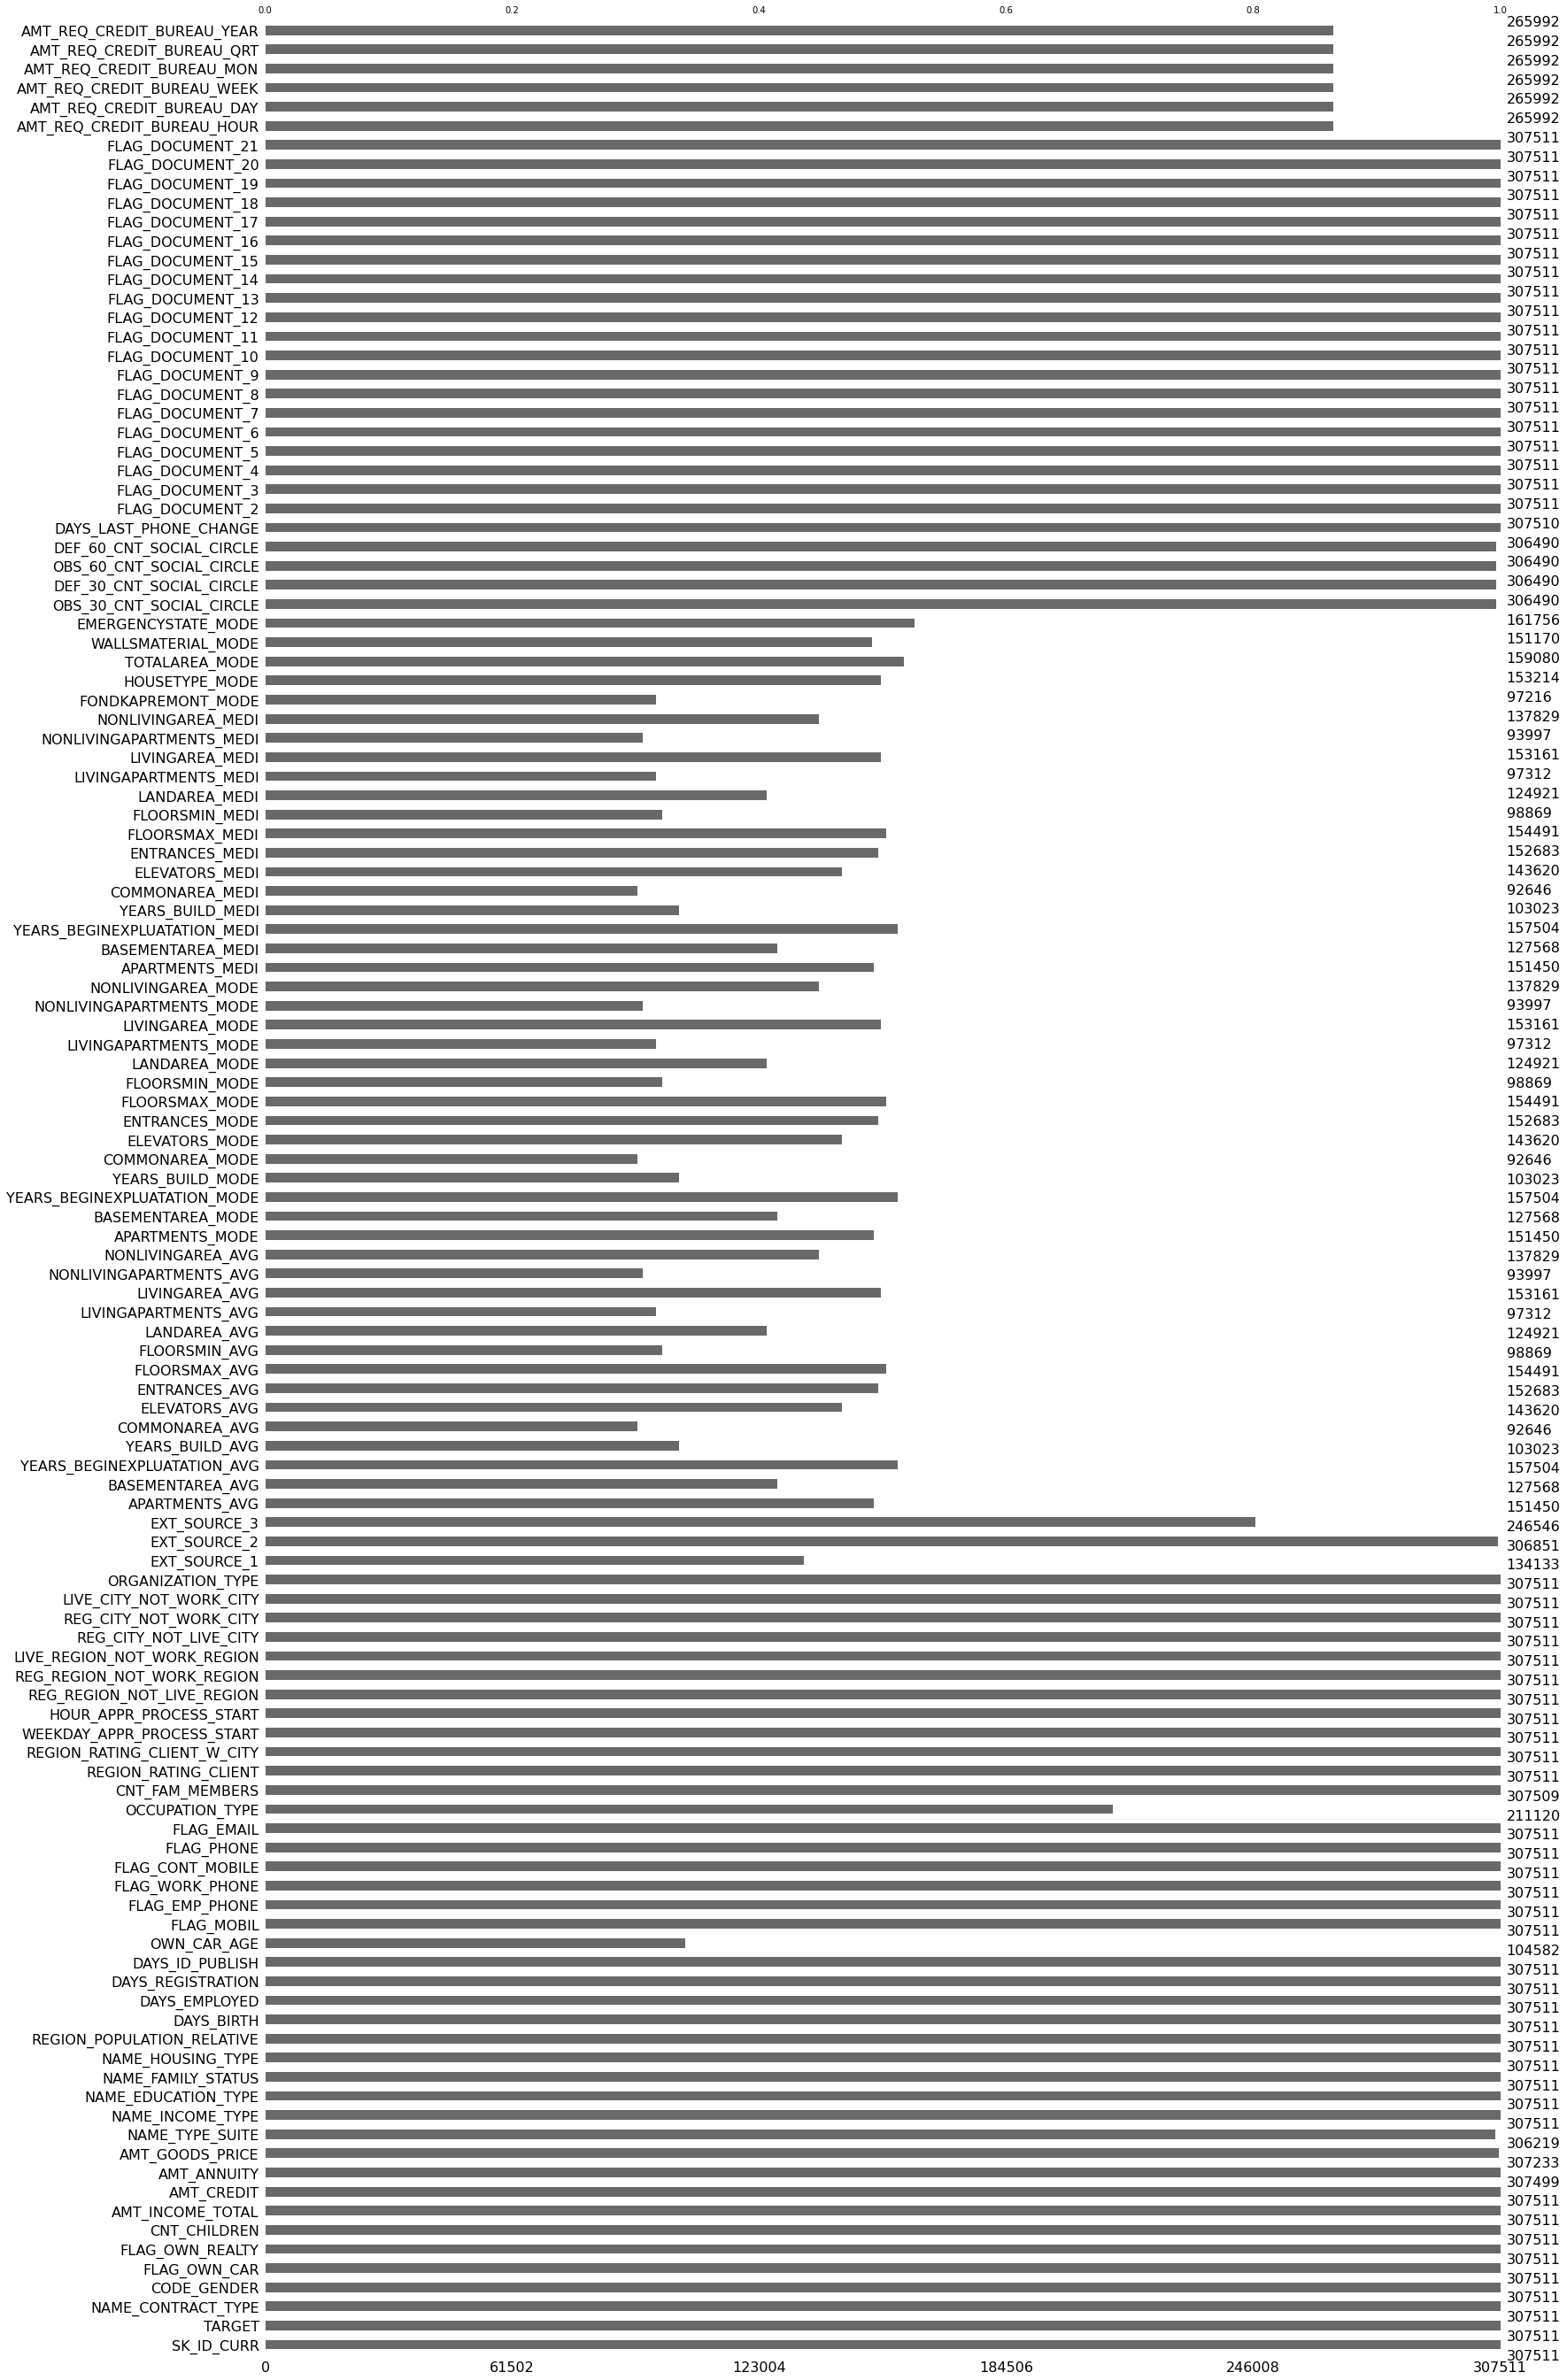

In [ ]:
msno.bar(d1)

In [ ]:
# Fonction affichant le taux de valeur manquante
def taux_manque(x):
    return x.isnull().sum()/d1.shape[0]*100

# Afficher toute la liste
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # On applique cette fonction pour chaque colonne:
    print("Pourcentage de valeurs manquantes par colonne:")
    print(d1.apply(taux_manque, axis=0).sort_values())

Pourcentage de valeurs manquantes par colonne:
SK_ID_CURR                       0.000000
HOUR_APPR_PROCESS_START          0.000000
REG_REGION_NOT_WORK_REGION       0.000000
LIVE_REGION_NOT_WORK_REGION      0.000000
REG_CITY_NOT_LIVE_CITY           0.000000
REG_CITY_NOT_WORK_CITY           0.000000
LIVE_CITY_NOT_WORK_CITY          0.000000
ORGANIZATION_TYPE                0.000000
FLAG_DOCUMENT_21                 0.000000
FLAG_DOCUMENT_20                 0.000000
FLAG_DOCUMENT_19                 0.000000
FLAG_DOCUMENT_18                 0.000000
FLAG_DOCUMENT_17                 0.000000
FLAG_DOCUMENT_16                 0.000000
FLAG_DOCUMENT_15                 0.000000
FLAG_DOCUMENT_14                 0.000000
FLAG_DOCUMENT_13                 0.000000
FLAG_DOCUMENT_12                 0.000000
FLAG_DOCUMENT_11                 0.000000
FLAG_DOCUMENT_10                 0.000000
FLAG_DOCUMENT_9                  0.000000
FLAG_DOCUMENT_8                  0.000000
FLAG_DOCUMENT_7              

Il y a 27 colonnes qui ont un taux de valeur manquante supérieur à 55%. Regardons les de plus près avant de les supprimer ou non

In [ ]:
# Extraire tableau avec valeur manquantes superieur ou égale à 55%
df_nan = d1.loc[:, d1.isnull().sum() >= 0.55*d1.shape[0]]

# Extraire la colonne TARGET et merger avec le df précédent suivant l'index
df_tar = d1['TARGET']
df_nan = df_nan.merge(df_tar, how='inner', left_index=True, right_index=True)

df_nan

OWN_CAR_AGE  EXT_SOURCE_1  ...  FONDKAPREMONT_MODE  TARGET
0               NaN      0.083037  ...    reg oper account       1
1               NaN      0.311267  ...    reg oper account       0
2              26.0           NaN  ...                 NaN       0
3               NaN           NaN  ...                 NaN       0
4               NaN           NaN  ...                 NaN       0
...             ...           ...  ...                 ...     ...
307506          NaN      0.145570  ...    reg oper account       0
307507          NaN           NaN  ...    reg oper account       0
307508          NaN      0.744026  ...    reg oper account       0
307509          NaN           NaN  ...                 NaN       1
307510          NaN      0.734460  ...                 NaN       0

[307511 rows x 28 columns]

In [ ]:
# voir la matrice de correlation pour voir s'il y a correlation avec la target
corr_df = df_nan.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

La plupart des colonnes avec beaucoup de valeurs manquantes contiennent des informations sur l'habitation et ont une corrélation de presque 0 avec la target (sauf EXT_SOURCE_1) nous pouvons donc les supprimer

In [ ]:
# Suppression des colonnes ayant plus de 58% de NaN
d1 = d1.loc[:, d1.isnull().sum() <= 0.58*d1.shape[0]]

d1.drop(["NONLIVINGAREA_MODE", "NONLIVINGAREA_AVG", "NONLIVINGAREA_MEDI"], axis =1, inplace = True)

De la même manière nous allons supprimer les autres colonnes concernant les informations sur le lieu d'habitation 

In [ ]:
d1 = d1.loc[:, ~d1.columns.str.endswith('_MODE')]
d1 = d1.loc[:, ~d1.columns.str.endswith('_AVG')]
d1 = d1.loc[:, ~d1.columns.str.endswith('_MEDI')]

Regardons maintenant les colonnes concernant les documents apporté par le client

In [ ]:
df_doc = d1.filter(regex='FLAG_DOCUMENT',axis=1)

df_doc.apply(pd.value_counts)

FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  ...  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21
0           307498            89171  ...            307355            307408
1               13           218340  ...               156               103

[2 rows x 20 columns]

On observe que la plupart du temps les documents ne sont pas apportés (sauf le document n°3) donc ils n'auront pas beacoup d'impact sur la modélisation, nous pouvons donc les supprimer

In [ ]:
d1 = d1.drop(d1.iloc[:,50:68], axis = 1)

d1.drop(['FLAG_DOCUMENT_2'], axis =1, inplace = True)

In [ ]:
correlation = d1.corr()['TARGET'].sort_values()

correlation

EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_EMPLOYED                 -0.044932
AMT_GOODS_PRICE               -0.039645
REGION_POPULATION_RELATIVE    -0.037227
AMT_CREDIT                    -0.030369
HOUR_APPR_PROCESS_START       -0.024166
FLAG_PHONE                    -0.023806
AMT_ANNUITY                   -0.012817
AMT_REQ_CREDIT_BUREAU_MON     -0.012462
AMT_INCOME_TOTAL              -0.003982
SK_ID_CURR                    -0.002108
AMT_REQ_CREDIT_BUREAU_QRT     -0.002022
FLAG_EMAIL                    -0.001758
FLAG_CONT_MOBILE               0.000370
FLAG_MOBIL                     0.000534
AMT_REQ_CREDIT_BUREAU_WEEK     0.000788
AMT_REQ_CREDIT_BUREAU_HOUR     0.000930
AMT_REQ_CREDIT_BUREAU_DAY      0.002704
LIVE_REGION_NOT_WORK_REGION    0.002819
REG_REGION_NOT_LIVE_REGION     0.005576
REG_REGION_NOT_WORK_REGION     0.006942
OBS_60_CNT_SOCIAL_CIRCLE       0.009022
OBS_30_CNT_SOCIAL_CIRCLE       0.009131


Garder les plus hautes correlations et ce qui semble important dans le domaine de la banque. Supprimer aussi les données sur le lieu d'habitation

In [ ]:
d1 = d1.drop(["REGION_POPULATION_RELATIVE", "HOUR_APPR_PROCESS_START","AMT_REQ_CREDIT_BUREAU_WEEK",
              "AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","LIVE_REGION_NOT_WORK_REGION",
              "REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION","OBS_60_CNT_SOCIAL_CIRCLE","OBS_30_CNT_SOCIAL_CIRCLE",
              "DEF_60_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","LIVE_CITY_NOT_WORK_CITY","DAYS_REGISTRATION",
              "REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY","DAYS_ID_PUBLISH",
              "REGION_RATING_CLIENT","REGION_RATING_CLIENT_W_CITY", "NAME_TYPE_SUITE" , 
              "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE", "AMT_REQ_CREDIT_BUREAU_MON",
             "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR", 
             "NAME_HOUSING_TYPE", "CNT_CHILDREN"], axis =1)

In [ ]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_CURR              307511 non-null  int64  
 1   TARGET                  307511 non-null  int64  
 2   NAME_CONTRACT_TYPE      307511 non-null  object 
 3   CODE_GENDER             307511 non-null  object 
 4   FLAG_OWN_CAR            307511 non-null  object 
 5   FLAG_OWN_REALTY         307511 non-null  object 
 6   AMT_INCOME_TOTAL        307511 non-null  float64
 7   AMT_CREDIT              307511 non-null  float64
 8   AMT_ANNUITY             307499 non-null  float64
 9   AMT_GOODS_PRICE         307233 non-null  float64
 10  NAME_INCOME_TYPE        307511 non-null  object 
 11  NAME_EDUCATION_TYPE     307511 non-null  object 
 12  NAME_FAMILY_STATUS      307511 non-null  object 
 13  DAYS_BIRTH              307511 non-null  int64  
 14  DAYS_EMPLOYED       

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


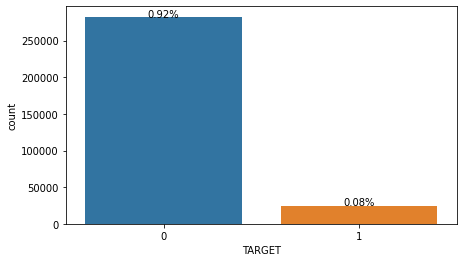

In [ ]:
plt.figure(figsize = (7, 4))
ax = sns.countplot(d1["TARGET"])

total = float(len(d1))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total),
            ha="center") 

In [ ]:
d1['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


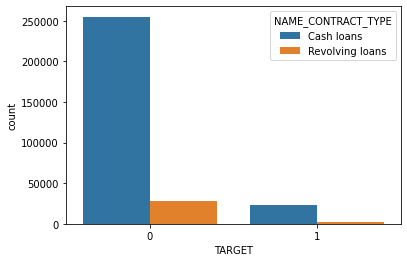

In [ ]:
ax = sns.countplot(d1['TARGET'], hue = d1['NAME_CONTRACT_TYPE'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


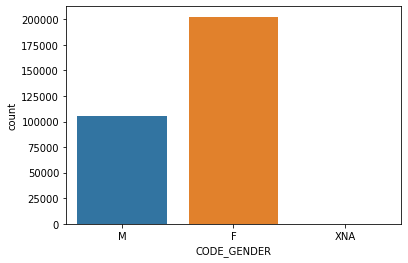

In [ ]:
sns.countplot(d1['CODE_GENDER'])

In [ ]:
d1["DAYS_BIRTH"].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

DAYS_BIRTH : l'âge du client en jours. On va modifier les valeurs en année

In [ ]:
# Ajouter l'âge du client en année
d1["Age"] = (d1['DAYS_BIRTH']/-365)

d1["Age"].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: Age, dtype: float64

Text(0.5, 1.0, "Distribution de l'âge des clients")

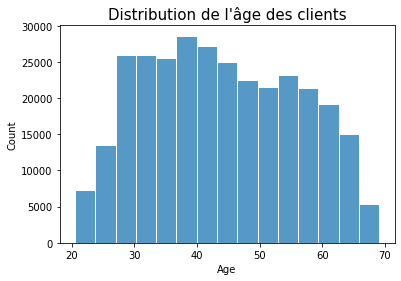

In [ ]:
sns.histplot(d1["Age"], bins = 15, edgecolor = 'white')
plt.title("Distribution de l'âge des clients", size = 15)

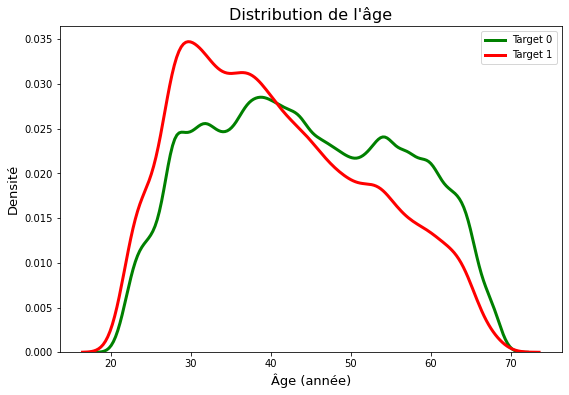

In [ ]:
plt.figure(figsize = (9, 6))

sns.kdeplot(d1.loc[d1['TARGET'] == 0, 'Age'], label = 'target == 0', color = 'green', linewidth=3)
sns.kdeplot(d1.loc[d1['TARGET'] == 1, 'Age'], label = 'target == 1', color = 'red', linewidth=3)
plt.xlabel('Âge (année)', size = 13)
plt.ylabel('Densité', size = 13) 
plt.title("Distribution de l'âge", size =16)
plt.legend(labels=["Target 0","Target 1"])

On remarque que les jeunes ont plus de difficultés de paiement. En effet target = 1 est moins élévée pour les client plus âgé que pour les client plus jeune

Text(0, 0.5, 'Nombre de defaut de paiement')

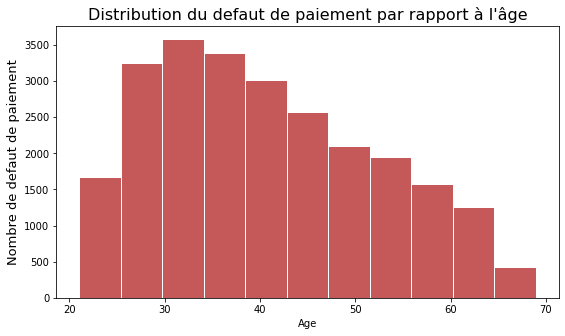

In [ ]:
# isoler les defauts de paiement
d_def = d1[d1['TARGET'] == 1]

# visualiser l'histogramme de l'age dans le cas de defaut de paiement
plt.figure(figsize = (9,5))
sns.histplot(d_def['Age'], bins = 11, color = 'firebrick', edgecolor = 'white')
plt.title("Distribution du defaut de paiement par rapport à l'âge", size = 16)
plt.ylabel("Nombre de defaut de paiement", size = 13)

In [ ]:
d1['Annee_travail'] = (d1["DAYS_EMPLOYED"]/-365).astype(int)

d1['Annee_travail'].describe()

count    307511.000000
mean       -175.121693
std         386.611073
min       -1000.000000
25%           0.000000
50%           3.000000
75%           7.000000
max          49.000000
Name: Annee_travail, dtype: float64

In [ ]:
d1['Annee_travail'].value_counts()

-1000    55374
 1       31841
 2       29648
 0       27904
 3       25107
 4       21767
 5       16271
 6       15051
 7       13148
 8       11440
 9        8980
 10       7364
 11       5902
 12       5309
 14       4643
 13       4349
 15       2725
 16       2335
 17       2006
 18       1918
 19       1871
 20       1600
 21       1461
 22       1253
 23       1016
 24        914
 25        821
 27        656
 26        653
 28        611
 29        567
 30        457
 31        437
 34        364
 32        351
 33        331
 35        257
 36        196
 37        138
 39        125
 38        116
 40         59
 41         59
 42         42
 44         31
 43         19
 45         14
 48          4
 46          4
 47          1
 49          1
Name: Annee_travail, dtype: int64

Il y a plus de 55.000 clients qui ont des données erronées au niveau du temps travaillé avant la demande de crédit. Ce serarit dommage de les supprimer, nous allons donc les remplacer par NaN

In [ ]:
d1['Annee_travail'] = np.where(d1['Annee_travail'] == -1000, np.nan, d1['Annee_travail'] )

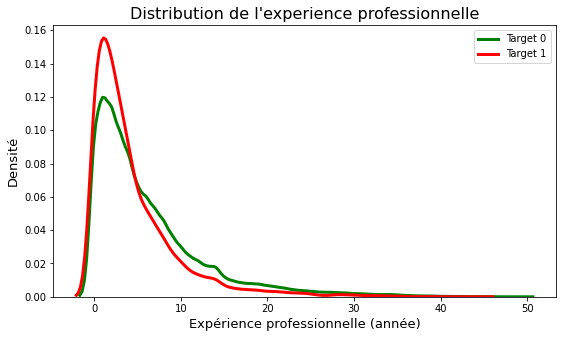

In [ ]:
plt.figure(figsize = (9, 5))

sns.kdeplot(d1.loc[d1['TARGET'] == 0, 'Annee_travail'], label = 'target == 0', color = 'green', linewidth=3)
sns.kdeplot(d1.loc[d1['TARGET'] == 1, 'Annee_travail'], label = 'target == 1', color = 'red', linewidth=3)
plt.xlabel('Expérience professionnelle (année)', size = 13)
plt.ylabel('Densité', size = 13) 
plt.title("Distribution de l'experience professionnelle", size =16)
plt.legend(labels=["Target 0","Target 1"])

Entre 5 et 30 ans de travail avant la demande de crédit le client a plus de chance de rembourser dans les temps. Avant 5 ans il y a plus de risques de non remboursement et après 30 ans les risques sont égaux. Cependant il n'y a pas de risque de non remboursement après 45 ans d'experience dans ce jeu de données

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


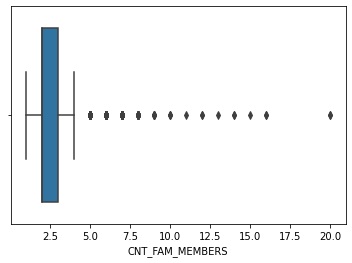

In [ ]:
sns.boxplot(d1['CNT_FAM_MEMBERS'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution du nombre de membre dans le foyer dans le group des defauts de paiement')

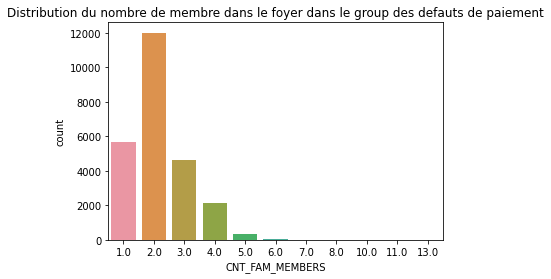

In [ ]:
sns.countplot(d_def['CNT_FAM_MEMBERS'])
plt.title('Distribution du nombre de membre dans le foyer dans le group des defauts de paiement')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


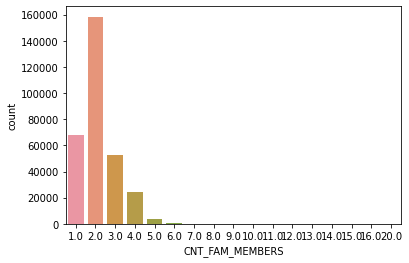

In [ ]:
sns.countplot(d1['CNT_FAM_MEMBERS'])

In [ ]:
d1['Percent_credit_revenu'] = d1['AMT_CREDIT'] / d1['AMT_INCOME_TOTAL']
d1['Percent_loyer_revenu'] = d1['AMT_ANNUITY'] / d1['AMT_INCOME_TOTAL']
d1['Duree'] = d1['AMT_ANNUITY'] / d1['AMT_CREDIT']

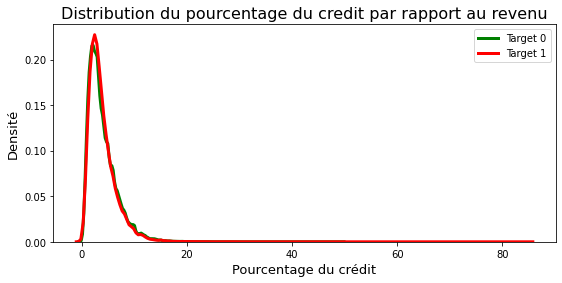

In [ ]:
plt.figure(figsize = (9, 4))

sns.kdeplot(d1.loc[d1['TARGET'] == 0, 'Percent_credit_revenu'], label = 'target == 0', color = 'green', linewidth=3)
sns.kdeplot(d1.loc[d1['TARGET'] == 1, 'Percent_credit_revenu'], label = 'target == 1', color = 'red', linewidth=3)
plt.xlabel('Pourcentage du crédit', size = 13)
plt.ylabel('Densité', size = 13) 
plt.title("Distribution du pourcentage du credit par rapport au revenu", size =16)
plt.legend(labels=["Target 0","Target 1"])

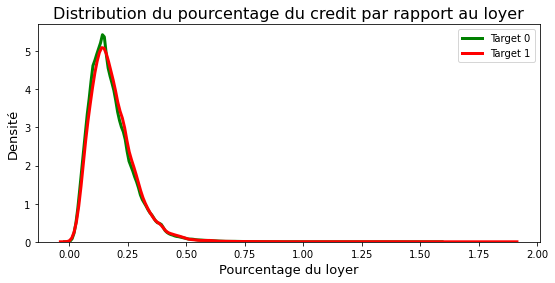

In [ ]:
plt.figure(figsize = (9, 4))

sns.kdeplot(d1.loc[d1['TARGET'] == 0, 'Percent_loyer_revenu'], label = 'target == 0', color = 'green', linewidth=3)
sns.kdeplot(d1.loc[d1['TARGET'] == 1, 'Percent_loyer_revenu'], label = 'target == 1', color = 'red', linewidth=3)
plt.xlabel('Pourcentage du loyer', size = 13)
plt.ylabel('Densité', size = 13) 
plt.title("Distribution du pourcentage du credit par rapport au loyer", size =16)
plt.legend(labels=["Target 0","Target 1"])

In [ ]:
d1 = d1.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis = 1)

# Enregistrer le fichier
d1.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [ ]:
d1 = pd.read_csv('/content/drive/MyDrive/data.csv')

### Autres base de données

In [ ]:
d2 = pd.read_csv('/content/drive/MyDrive/previous_application.csv')

d2.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [ ]:
d2['Duree_prec'] = d2['AMT_ANNUITY']/d2['AMT_CREDIT']

In [ ]:
d2 = d2[['SK_ID_CURR', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'Duree_prec' ]]

In [ ]:
d3 = pd.read_csv('/content/drive/MyDrive/bureau.csv')
d3.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [ ]:
d3 = d3[['SK_ID_CURR', 'CREDIT_ACTIVE', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE',
        'AMT_CREDIT_SUM']]

In [ ]:
from functools import reduce

# Merger les 3 bases de données 
data = [d1, d2, d3]
df = reduce(lambda  x, y: pd.merge(x, y, on=['SK_ID_CURR'], how='outer'), data)

df.shape

(9673993, 37)

In [ ]:
# Supprimer lignes où la target n'est pas connu
df = df[df['TARGET'].notna()]

df.shape

(8091522, 37)

In [ ]:
# Supprimer les données dupliquées
df = df.drop_duplicates()

df.shape

(6510484, 37)

In [ ]:
#Supprimer les lignes qui moins de 31 colonnes non NaN
df = df.dropna(axis = 0, thresh=31)

df.shape

(6475589, 37)

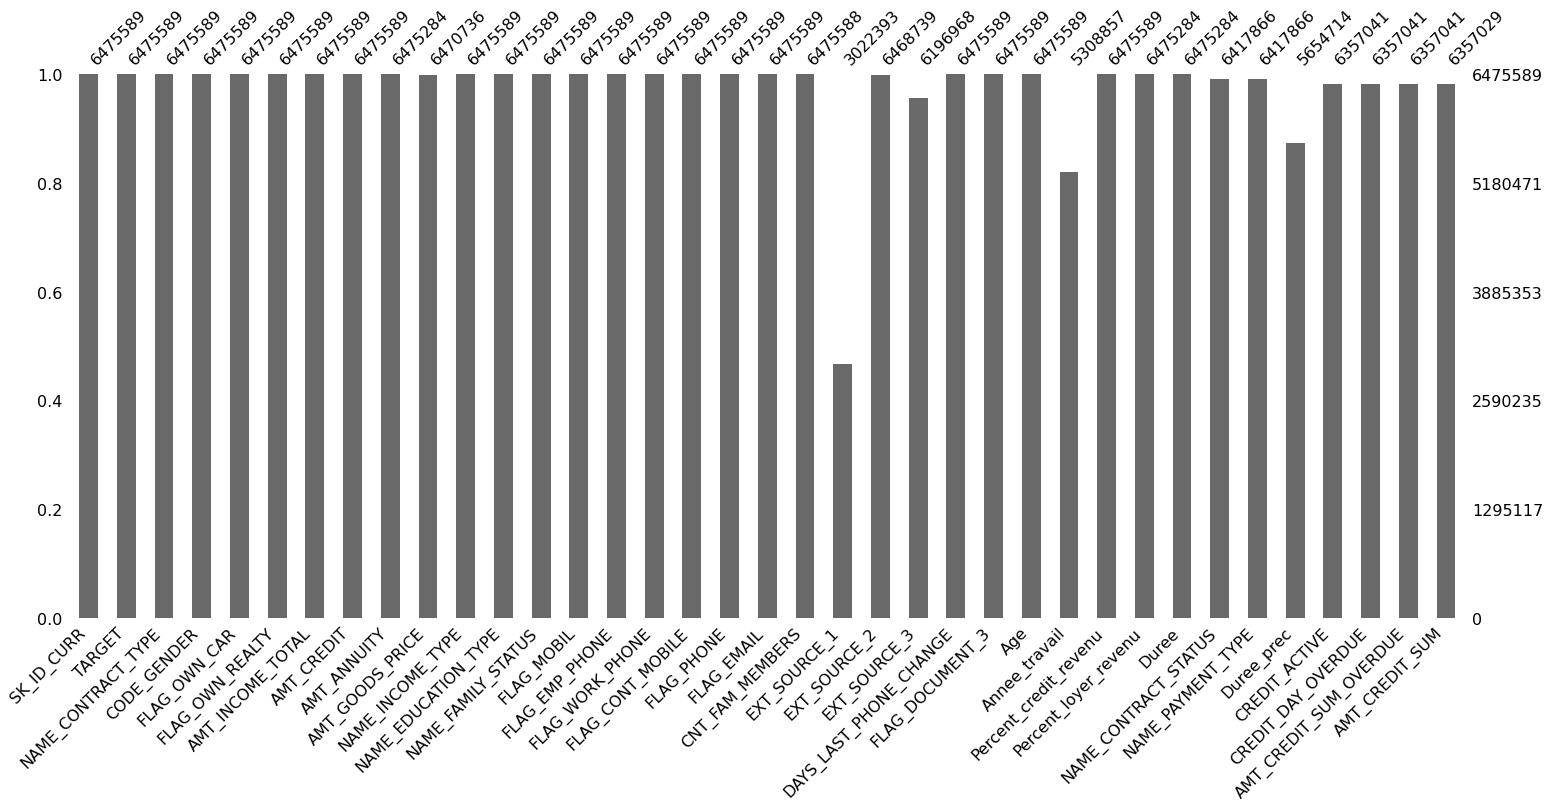

In [ ]:
msno.bar(df)

In [ ]:
df.to_csv('P7.csv')
!cp P7.csv "drive/My Drive/"

# 2) Pre-processing

Après avoir testé le modèle avec les 3 dataset mergé j'ai choisi de garder seulement le premier dataset nettoyé car le notebook tournait trop lentement et finissait souvent par cracher

In [2]:
#Chargement du premier dataset nettoyé
df = pd.read_csv('/content/drive/MyDrive/data.csv')

df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [3]:
df.corr()['TARGET'].sort_values()

EXT_SOURCE_3             -0.178919
EXT_SOURCE_2             -0.160472
EXT_SOURCE_1             -0.155317
Age                      -0.078239
Annee_travail            -0.074757
AMT_GOODS_PRICE          -0.039645
AMT_CREDIT               -0.030369
FLAG_PHONE               -0.023806
AMT_ANNUITY              -0.012817
Percent_credit_revenu    -0.007727
AMT_INCOME_TOTAL         -0.003982
SK_ID_CURR               -0.002108
FLAG_EMAIL               -0.001758
FLAG_CONT_MOBILE          0.000370
FLAG_MOBIL                0.000534
CNT_FAM_MEMBERS           0.009308
Duree                     0.012704
Percent_loyer_revenu      0.014265
FLAG_WORK_PHONE           0.028524
FLAG_DOCUMENT_3           0.044346
FLAG_EMP_PHONE            0.045982
DAYS_LAST_PHONE_CHANGE    0.055218
TARGET                    1.000000
Name: TARGET, dtype: float64

Il n'y a pas de forte correlation avec la target, nous pouvons donc utiliser toutes ces colonnes en tant que feature pour nos modélisations

## 2.1) Imputer les valeurs manquantes

In [4]:
df.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                   12
AMT_GOODS_PRICE              278
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
CNT_FAM_MEMBERS                2
EXT_SOURCE_1              173378
EXT_SOURCE_2                 660
EXT_SOURCE_3               60965
DAYS_LAST_PHONE_CHANGE         1
FLAG_DOCUMENT_3                0
Age                            0
Annee_travail              55374
Percent_credit_revenu          0
Percent_loyer_revenu          12
Duree                         12
dtype: int

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

numeric_feat = make_column_selector(dtype_include = np.number)
categoric_feat = make_column_selector(dtype_exclude = np.number)

In [6]:
from sklearn.impute import SimpleImputer

# Imputer les valeurs numerique par la mediane
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(df[numeric_feat])

In [7]:
df[numeric_feat] = imputer.transform(df[numeric_feat])

df.isnull().sum()

SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
AMT_INCOME_TOTAL          0
AMT_CREDIT                0
AMT_ANNUITY               0
AMT_GOODS_PRICE           0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
FLAG_MOBIL                0
FLAG_EMP_PHONE            0
FLAG_WORK_PHONE           0
FLAG_CONT_MOBILE          0
FLAG_PHONE                0
FLAG_EMAIL                0
CNT_FAM_MEMBERS           0
EXT_SOURCE_1              0
EXT_SOURCE_2              0
EXT_SOURCE_3              0
DAYS_LAST_PHONE_CHANGE    0
FLAG_DOCUMENT_3           0
Age                       0
Annee_travail             0
Percent_credit_revenu     0
Percent_loyer_revenu      0
Duree                     0
dtype: int64

## 2.2) Encodage des valeurs categorielles

Les features de type object ne sont pas ordinal nous allons donc utiliser le OnHotEncoder

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_CURR              307511 non-null  float64
 1   TARGET                  307511 non-null  float64
 2   NAME_CONTRACT_TYPE      307511 non-null  object 
 3   CODE_GENDER             307511 non-null  object 
 4   FLAG_OWN_CAR            307511 non-null  object 
 5   FLAG_OWN_REALTY         307511 non-null  object 
 6   AMT_INCOME_TOTAL        307511 non-null  float64
 7   AMT_CREDIT              307511 non-null  float64
 8   AMT_ANNUITY             307511 non-null  float64
 9   AMT_GOODS_PRICE         307511 non-null  float64
 10  NAME_INCOME_TYPE        307511 non-null  object 
 11  NAME_EDUCATION_TYPE     307511 non-null  object 
 12  NAME_FAMILY_STATUS      307511 non-null  object 
 13  FLAG_MOBIL              307511 non-null  float64
 14  FLAG_EMP_PHONE      

In [9]:
df = pd.get_dummies(df)
df.shape

(307511, 51)

## 2.3) Standardisation des données

In [10]:
# Choisir les features
X = df.drop(['TARGET', 'SK_ID_CURR'], axis = 1)

# Et le target:
Y = df.iloc[:,1:2] 

In [11]:
X.columns = X.columns.str.replace('[/, _]', ' ')
X.rename(columns={'NAME EDUCATION TYPE Secondary   secondary special': 'NAME EDUCATION TYPE Secondary',
                  'NAME FAMILY STATUS Single   not married': 'NAME FAMILY STATUS Single'}, inplace=True)

In [12]:
# Créer dictionnaire avec les noms de colonnes et leurs indices avant la standardisation
d = dict()
for id, col in enumerate(X.columns):
    d[col] = id

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xs = scaler.fit_transform(X) 

In [14]:
#Transformer les données standardisé en dataframe
Xs_df = pd.DataFrame(data = Xs, columns = X.columns)

Xs_df.head(3)

AMT INCOME TOTAL  ...  NAME FAMILY STATUS Widow
0          0.142129  ...                 -0.234957
1          0.426792  ...                 -0.234957
2         -0.427196  ...                 -0.234957

[3 rows x 49 columns]

In [15]:
#Xs_df.to_csv('X_scal.csv')
#!cp X_scal.csv "drive/My Drive/"

In [16]:
from sklearn.model_selection import train_test_split

#Sélection des données d'entrainement (80%) et de test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(Xs, Y,  test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 246008 lignes,
Test: 61503 lignes.



## 2.4) Rééchantillonage des données

SMOTE (Synthetic Minority Oversampling TEchnique) consiste à synthétiser des éléments pour la classe minoritaire, à partir de ceux qui existent déjà. Cela fonctionne en sélectionnant aléatoirement un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


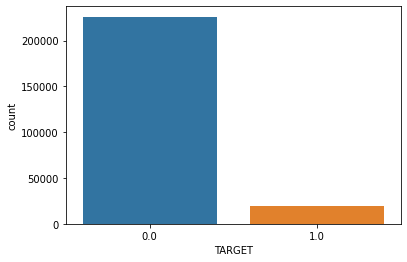

In [17]:
sns.countplot(Y_train['TARGET'])

Pour éviter le sur-apprentissage nous allons faire du rééchantillonnage sur les données d'entrainement seulement

In [18]:
from imblearn.over_sampling import SMOTE

smot = SMOTE(sampling_strategy = 0.25 , n_jobs=0, random_state=0)
X_trains, Y_trains = smot.fit_resample(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


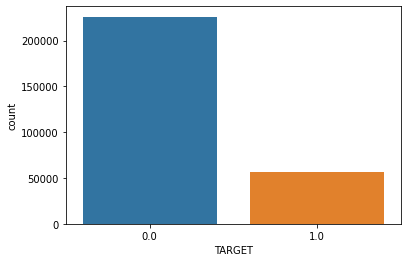

In [19]:
sns.countplot(Y_trains['TARGET'])

En fin de compte nous n'allons pas utiliser les données sur-échantillonné car ils n'apportent pas plus d'amélioration au modèle

# 3) Modélisation

In [ ]:
from sklearn.metrics import fbeta_score, make_scorer

#Génerer objet de scoring
fb_scorer = make_scorer(fbeta_score, beta=2)

## 3.1) RandomForestClassifier

### 3.1.1) Choix des hyperparamètres

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 'max_features': [0.65, 0.75],
              'min_samples_split': [3, 6]}

grid = GridSearchCV(RandomForestClassifier(n_estimators = 400, max_depth=50, class_weight={0:1,1:9}), param_grid, cv = 2, scoring = fb_scorer )
grid.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 9},
                                              max_depth=50, n_estimators=400),
             param_grid={'max_features': [0.65, 0.75],
                         'min_samples_split': [3, 6]},
             scoring=make_scorer(fbeta_score, beta=2))

In [ ]:
print(grid.best_score_)

grid.best_params_

0.03304334899593462


{'max_features': 0.75, 'min_samples_split': 6}

Après avoir lancé plusieurs GridSearch en testant les paramètres 2 par 2 (ca cause des problèmes de memoire) on trouve que les meilleurs paramètres sont 'max_depth'= 50, 'n_estimators' = 400, 'max_features'= 0.8 et 'min_samples_split': 2

### 3.1.2) Prédiction

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(max_depth = 50, max_features = 0.75, n_estimators= 400, min_samples_split= 6, class_weight={0:1,1:10} )

rfc.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=50,
                       max_features=0.75, min_samples_split=6,
                       n_estimators=400)

In [ ]:
predict = rfc.predict(X_test)

print(rfc.score(X_test, Y_test))

0.9155325756467164


### 3.1.3) Métriques

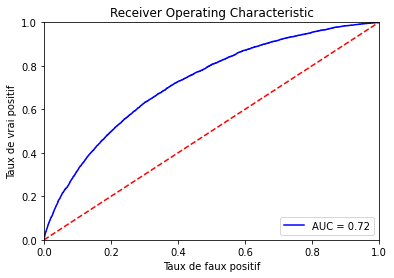

In [ ]:
import sklearn.metrics as metrics


# calculate the fpr and tpr for all thresholds of the classification
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrai positif')
plt.xlabel('Taux de faux positif')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, predict)

array([[56046,   508],
       [ 4687,   262]])

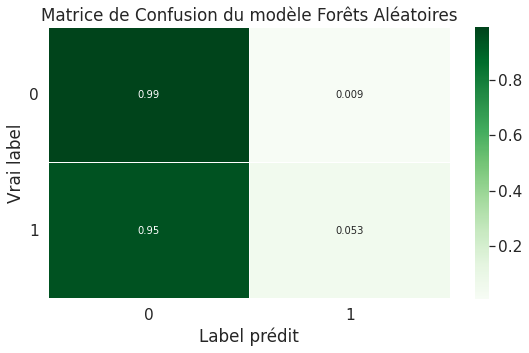

In [ ]:
import matplotlib.pyplot as plt


matrix = confusion_matrix(Y_test, predict)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['0', '1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks + 0.5, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.title('Matrice de Confusion du modèle Forêts Aléatoires')
plt.show()

In [ ]:
from sklearn.metrics import fbeta_score

fbeta_score(Y_test, predict, average='weighted', beta=0.5)

0.873538344836453

En se basant uniquement sur les scores le modèle semble bon mais d'après la matrice de confusion 

<BarContainer object of 50 artists>

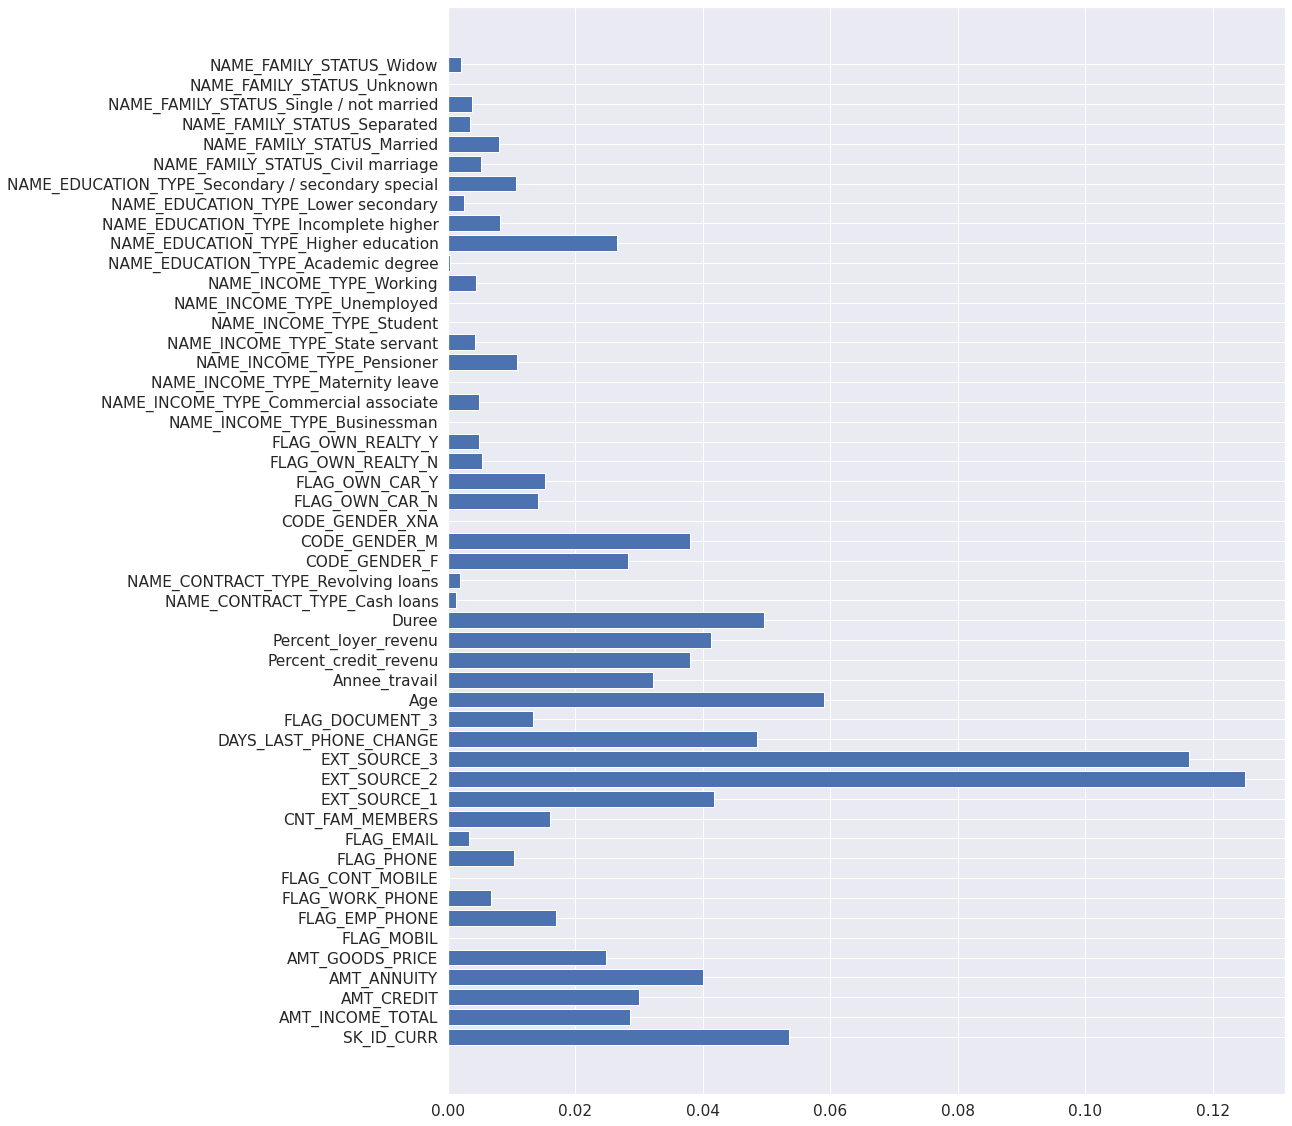

In [ ]:
plt.subplots(figsize = (15, 20))
plt.barh(X.columns, rfc.feature_importances_)

## 3.2) Light GBM Classifier

### 3.2.1) Hyperparamètres

In [ ]:
#from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats

lgbm = lgb.LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='binary_logloss',
                      n_jobs=-1,
                      n_estimators=200,
                      scale_pos_weight=15 )

lgbm_param = {'num_leaves': np.linspace(10, 80, 7, dtype='int'),
              'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
              'subsample': (0.2, 0.5, 0.8),
              'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=10,
                          cv=3,
                          scoring=fb_scorer,
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

In [ ]:
grid.fit(X_train, Y_train)

print(round(grid.best_score_, 3))
print()
print('Les meilleurs paramètres sont:')
print(grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


0.423

Les meilleurs paramètres sont:
{'colsample_bytree': 0.43510749512924485, 'min_child_weight': 100.0, 'num_leaves': 45, 'reg_alpha': 10, 'reg_lambda': 50, 'subsample': 0.5}


### 3.2.2) Modelisation

In [ ]:
model = grid.best_estimator_
model.fit(X_train, Y_train)

y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 1]
y_prob = np.where(y_pred >= 0.5, 1, 0)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
# Vérifier si le modèle a bien été fité
from sklearn.utils.validation import check_is_fitted
print(check_is_fitted(model))

None


In [ ]:
import pickle
pickle.dump(model, open('final_prediction.pickle', 'wb'))

### 3.2.3) Métriques

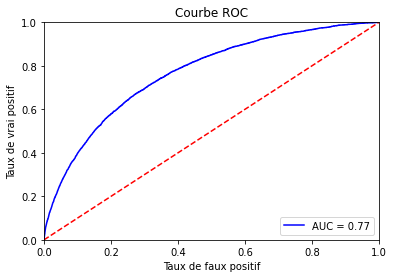

In [ ]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(Y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Courbe ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrai positif')
plt.xlabel('Taux de faux positif')
plt.show()

In [ ]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix


print(fbeta_score(Y_test, y_prob, average='weighted', beta=0.5))
print()
confusion_matrix(Y_test, y_prob)

0.820399212365881



array([[35973, 20581],
       [ 1209,  3740]])

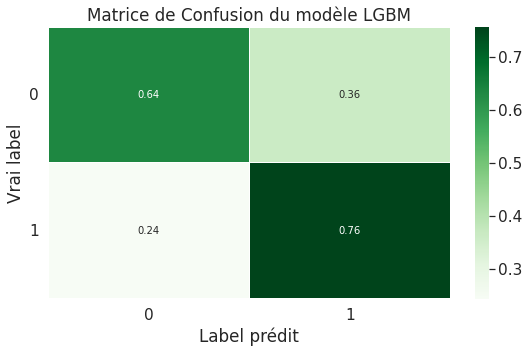

In [ ]:
matrix = confusion_matrix(Y_test, y_prob)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['0', '1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks + 0.5, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.title('Matrice de Confusion du modèle LGBM')
plt.show()

### 3.2.4) Explainer et feature importance

In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 4.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=2cc10975925bcb9ebf8bbd1152bcc70b82d319bce03f471d72ce248d7a22a18d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
                                              feature_names=X.columns,
                                              class_names=['0', '1'],
                                              mode='classification')

In [ ]:
exp = explainer.explain_instance(data_row=X.iloc[5], 
                                predict_fn=model.predict_proba,
                                 num_features=15)

exp.show_in_notebook(show_table=True,  show_predicted_value=True)

In [ ]:
exp.local_pred*100

array([27.43523379])

In [ ]:
exp = explainer.explain_instance(data_row=X.iloc[55], 
                                predict_fn=model.predict_proba,
                                 num_features=25)

exp.show_in_notebook(show_table=True,  show_predicted_value=True)

<BarContainer object of 49 artists>

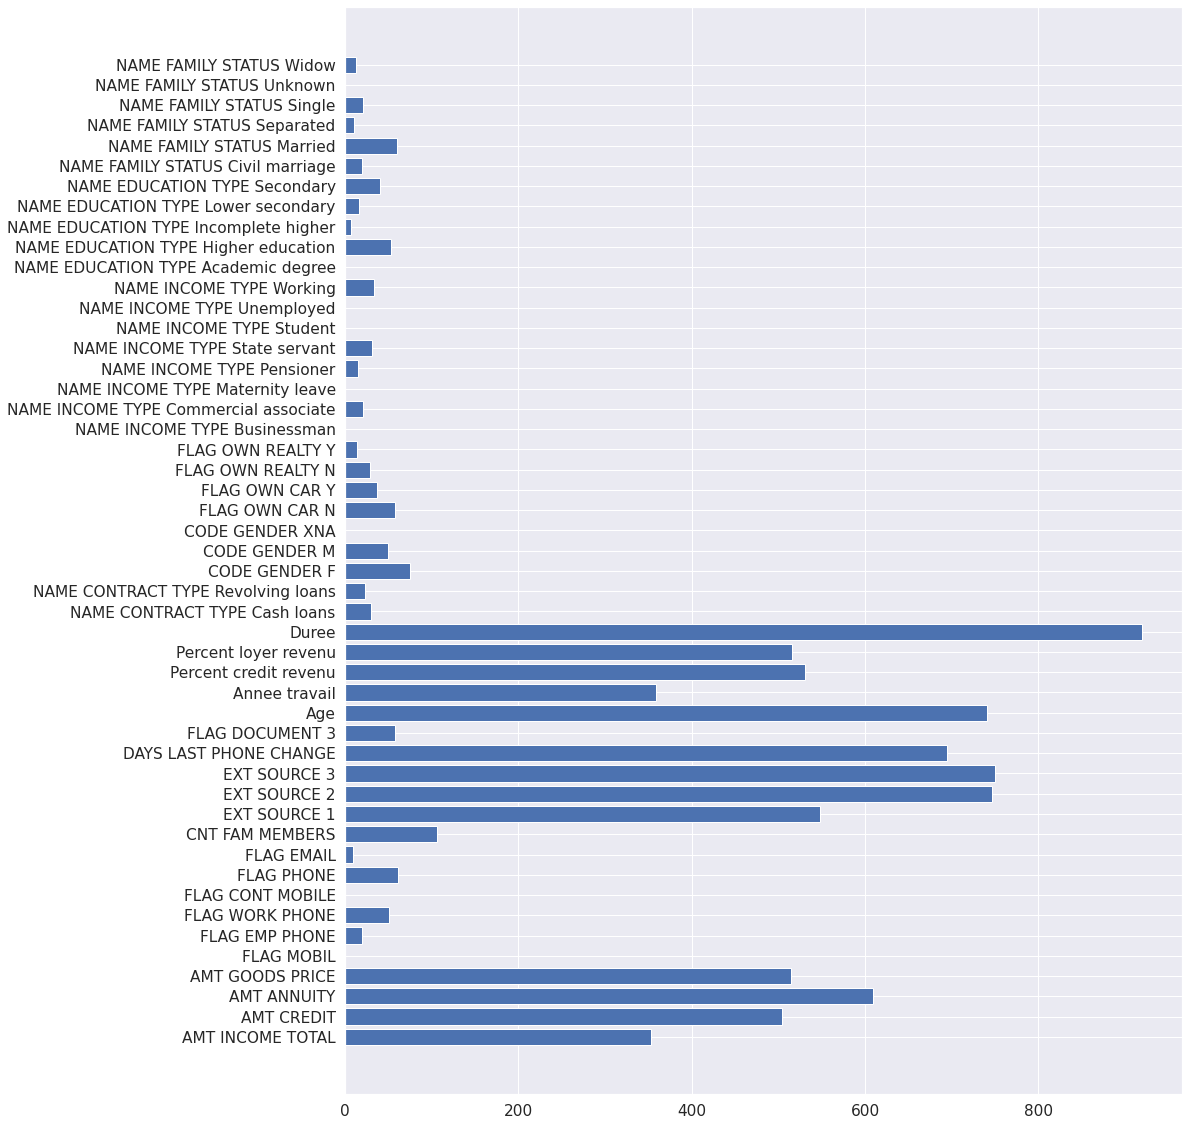

In [ ]:
plt.subplots(figsize = (15, 20))
plt.barh(X.columns, model.feature_importances_)

In [ ]:
# Creer dataframe avec feature importance correspondnt au feature trié par ordre decroissant
imp = pd.DataFrame(data = model.feature_importances_  , index  = X.columns, columns = ['Feature importance'])
imp = imp.sort_values(by= ['Feature importance'], ascending=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text major ticklabel objects>)

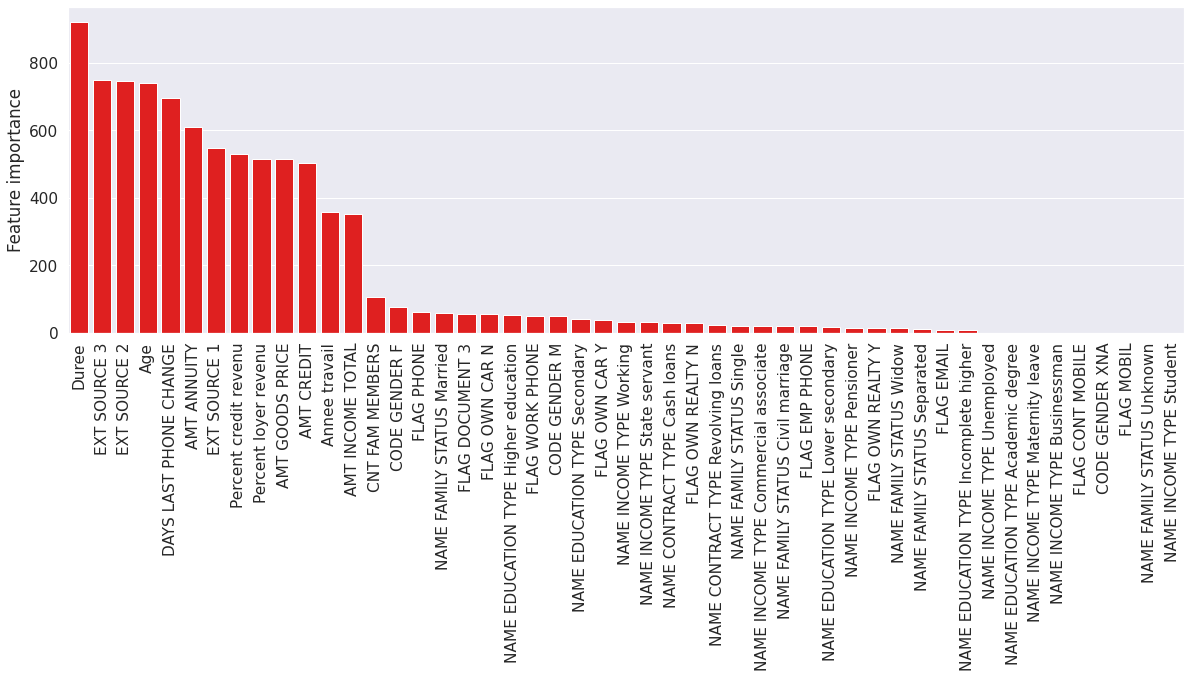

In [ ]:
plt.subplots(figsize = (20, 6))
sns.barplot(x=imp.index, y ='Feature importance', data=imp, color ='red')
plt.xticks(rotation =90)


# 4) Pipeline

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(), StandardScaler())

cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown = "ignore")) 

In [ ]:
# Récuperer les colonnes et les indices des valeurs numeriques
columns_cat = ["FLAG OWN CAR N", 'FLAG OWN CAR Y',
             'FLAG OWN REALTY N', 'FLAG OWN REALTY Y',
            'NAME CONTRACT TYPE Cash loans', 'NAME CONTRACT TYPE Revolving loans',
            'NAME EDUCATION TYPE Academic degree', 'NAME EDUCATION TYPE Higher education',
            'NAME EDUCATION TYPE Incomplete higher', 'NAME EDUCATION TYPE Lower secondary',
            'NAME EDUCATION TYPE Secondary',
            'NAME FAMILY STATUS Civil marriage', 'NAME FAMILY STATUS Married', 'NAME FAMILY STATUS Separated',
            'NAME FAMILY STATUS Single', 'NAME FAMILY STATUS Unknown', 'NAME FAMILY STATUS Widow',
            'NAME INCOME TYPE Businessman', 'NAME INCOME TYPE Commercial associate', 'NAME INCOME TYPE Maternity leave', 'NAME INCOME TYPE Pensioner',
            'NAME INCOME TYPE State servant', 'NAME INCOME TYPE Student', 'NAME INCOME TYPE Unemployed', 'NAME INCOME TYPE Working']

categoric_feature = [d[col] for col in columns_cat]

# Recuperer les colonnes et les indices des valeurs numeriques
columns_num = d.keys() - columns_cat

numeric_feature = [d[col] for col in columns_num]

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[("num", num_pipeline, numeric_feature),
                                               ("cat", cat_pipeline, categoric_feature)])

In [ ]:
from sklearn.pipeline import Pipeline

prep_pip = Pipeline( steps=[("preprocessor", preprocessor)])

In [ ]:
from sklearn.pipeline import Pipeline


clf = Pipeline( steps=[("preprocessor", prep_pip), 
                       ("classifier", grid.best_estimator_)])
                           
                               

In [ ]:
clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   [12, 18, 2,
                                                                    1, 16, 5,
                                                                    11, 3, 4,
                                                                    17, 0, 9,
                                                                    15, 19, 25,
                                        

In [ ]:
clf.score(X_test, Y_test)

0.6294652293384062

In [ ]:
import joblib

joblib.dump(clf, 'pipeline_p7.pkl')

['pipeline_p7.pkl']

# 5) API: Mlflow

In [ ]:
pip install mlflow

     |████████████████████████████████| 15.6 MB 7.0 MB/s 
     |████████████████████████████████| 146 kB 52.4 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 209 kB 29.2 MB/s 
     |████████████████████████████████| 180 kB 58.0 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 75 kB 5.2 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.2-py3-none-any.whl size=106811 sha256=447353c09834b1ceedf4ac751e5ce6db97d3bb555c650525217da1d6b0851161
  Stored in directory: /root/.cache/pip/wheels/f4/5c/ed/e1ce20a53095f63b27b4964abbad03e59cf3472822addf7d29
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [ ]:
from mlflow.models.signature import infer_signature

# Extraire la signature à partir des données d'entrée et de sortie.
signature = infer_signature(X_train, Y_train)

In [ ]:
import mlflow.sklearn

# Sauvgarder le model avec la signature
mlflow.sklearn.save_model(model, 'mlflow_model', signature=signature)

2022/01/28 15:26:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: mlflow_model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==1.3.0']. Set logging level to DEBUG to see the full traceback.
